# Linear neural networks

## Problem description

Predict the price of flat in Wurzbrug based on its size (in sqm) and time since last renovation (in yrs).

* input: $\mathbf{x} \in \mathbb{R}^2$
* output: $y \in \mathbb{R}$

In [110]:
# import torch
import torch 

### Generate synthetic data

Generate some data which are a bit similar to reality:

* sizes from normal distribution with mean 70 and std 20
* years from normal distribution with mean 5 and std 2
* clamp the input data into reasonable values (e.g. sizes btw $[20, 150]$, years btw $[0, 10]$)

In [111]:
# Fix number of data examples (e.g. to 1000)
n=1000
# generate random input data
x1 = torch.normal(70,20,(n,1))
x2 = torch.normal(5,2,(n,1))
# clamp all entries of a tensor to a limit range
x1 = torch.clamp(x1,min=20,max=150)
#x1 = x1.clamp(min=20,max=150)   this syntax is also correct!
#x1.clamp_(min=20,max=150)    it is replacement assignment (_) directly apply to the object
x2 = torch.clamp(x2,min=0,max=10)
# make sure the iputs are a single tensor with 2 colums
x = torch.cat((x1,x2),dim=1)
print(x1.min(),x1.max())
print(x2.min(),x2.max())
x
# If we need the same numbers for our sample everytime, 
# we need to set the seed to a fix number, otherwise it will creat random numbers

tensor(20.) tensor(133.1282)
tensor(0.) tensor(10.)


tensor([[71.7092,  7.1588],
        [48.6666,  2.9788],
        [92.3241,  5.1651],
        ...,
        [48.8530,  5.7707],
        [98.9794,  3.5932],
        [77.9942,  1.3135]])

### Generate synthetic labels

We are working with liner model so assume labels are generated as $y = \mathbf{x}^T \mathbf{w} + b + e$, where $e$ is random gaussian noise.

Fix true parameters to the following values:

* weight for size = 10.
* weight for years = -20.
* bias = 100
* random noise is Gaussian with mean 0. and standard deviation 5.

In [112]:
# fix true parameters for the linear regression
w_true = torch.tensor([10., -20.])
w_true.shape
# bias
b_true = 100.
# generate outputs from linear regression model y = x^T w + b + e
y = x.matmul(w_true) + b_true + torch.normal(0.,5.,(n,))
y.shape

torch.Size([1000])

### Plot data

Use matplotlib library to plot a scatter graph of price against the size of the apartment

Text(0, 0.5, 'Price')

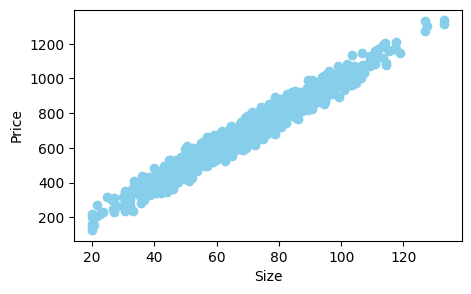

In [113]:
# use matplilib to plot a scatter of price against the size
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(5,3))
plt.plot(x[:,0],y,'o',color='skyblue')
plt.xlabel('Size')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

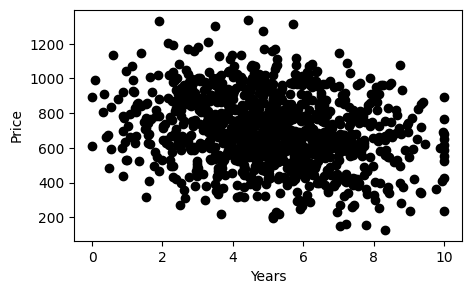

In [114]:
fig=plt.figure(figsize=(5,3))
plt.plot(x[:,1],y,'o',color='black')
plt.xlabel('Years')
plt.ylabel('Price')

### Data loading

Write a generator to load batches of data. It shall recieve as arguments the data inputs, outputs and the batch size and yield a batch of examples at every call, where batch is a tuple of inuts and outputs in the batch. Remember to shuffle the data at the initiation of the generator so that you do not get always the same batches.

In [115]:
list_num=torch.arange(10)
list_num

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [116]:
for i in list_num:
  print(i)

tensor(0)
tensor(1)
tensor(2)
tensor(3)
tensor(4)
tensor(5)
tensor(6)
tensor(7)
tensor(8)
tensor(9)


In [117]:
# define a function (generator) iter_data(inputs, outputs, batch_size) -> (batch_inputs, batch_outputs)
def iter_data():
  for i in range(10):
    yield i

#generator=iter_data()
#for i in generator:
#  print(i)

In [118]:
gen=iter_data()
gen

<generator object iter_data at 0x7fd34311dee0>

In [119]:
next(gen)

0

In [120]:
torch.randperm(10)

tensor([0, 3, 7, 2, 5, 1, 9, 6, 4, 8])

In [121]:
def iter_data(inputs,outputs,batch_size):
  n = inputs.size(0)
  idx = torch.arange(n)
  for i in range (0,n,batch_size):
    batch_idx = idx[i:i+batch_size]
    batch = inputs[batch_idx], outputs[batch_idx]
    yield batch

In [122]:
batches= iter_data(x,y,8)
batches

<generator object iter_data at 0x7fd34311de70>

In [123]:
next(batches)

(tensor([[ 71.7092,   7.1588],
         [ 48.6666,   2.9788],
         [ 92.3241,   5.1651],
         [ 60.4596,   4.2244],
         [ 81.2585,   1.8913],
         [ 30.7381,   5.8189],
         [100.7884,   2.6704],
         [ 71.1654,   4.6276]]),
 tensor([ 674.9715,  525.5783,  919.2273,  616.2650,  884.1013,  291.2843,
         1048.8212,  728.7076]))

### Iterate through data

Check your generator works by iterating once through all the data and printing out the batch at every iteration.

In [124]:
# write a for loop to load batches from data and print out the batches
for batch in iter_data(x,y,5):
  print(batch)

(tensor([[71.7092,  7.1588],
        [48.6666,  2.9788],
        [92.3241,  5.1651],
        [60.4596,  4.2244],
        [81.2585,  1.8913]]), tensor([674.9715, 525.5783, 919.2273, 616.2650, 884.1013]))
(tensor([[ 30.7381,   5.8189],
        [100.7884,   2.6704],
        [ 71.1654,   4.6276],
        [ 99.5123,   4.8808],
        [ 71.2512,   6.0336]]), tensor([ 291.2843, 1048.8212,  728.7076,  998.0773,  690.6642]))
(tensor([[75.2402,  1.2240],
        [34.2874,  3.2306],
        [79.5843,  1.5398],
        [66.1666,  6.5588],
        [61.5539,  7.3956]]), tensor([827.0347, 381.4653, 855.4655, 639.3265, 561.2996]))
(tensor([[104.1992,   4.0432],
        [ 85.5189,   9.0869],
        [ 63.4252,   5.0497],
        [ 54.9195,   2.8162],
        [ 87.0104,   3.6708]]), tensor([1071.4805,  774.0330,  628.2068,  587.3008,  897.3726]))
(tensor([[9.7594e+01, 4.2010e+00],
        [8.2189e+01, 7.3334e+00],
        [1.0635e+02, 7.8928e+00],
        [8.9314e+01, 7.2571e-02],
        [7.1090e+01, 

### Model definition

We work with linear regression so we need to define a linear regression model as $\hat{y} = \mathbf{x}^T \mathbf{w} + b$.
Here $\mathbf{w}$ and $b$ are the unknown parameters that we need to learn.

In [125]:
# define a function lin_reg(inputs, weight, bias) -> y_hat 
def lin_reg(inputs,weight,bias):
  y_hat=inputs.matmul(weight)+bias
  return y_hat

In [126]:
# use true parameters and check errors
y_hat = lin_reg(x,w_true,b_true)
errors = y_hat - y
errors

tensor([-1.0554e+00,  1.5114e+00,  7.1204e-01,  3.8432e+00, -9.3412e+00,
        -2.8125e-01,  5.6539e+00, -9.6042e+00, -5.6952e-01,  1.1763e+00,
         8.8727e-01, -3.2026e+00,  9.5816e+00, -8.8361e+00,  6.3278e+00,
        -1.0353e+01, -5.8228e-01,  5.0504e+00,  5.5706e+00, -6.8506e-01,
         5.1935e+00, -3.6040e+00,  3.0919e+00, -1.0009e+00, -2.6892e+00,
        -1.0872e+00, -9.6988e+00,  3.8713e+00, -4.5641e+00, -5.2338e-01,
         7.1832e-01, -4.2710e+00,  6.9702e-01,  3.0980e+00,  3.0740e+00,
        -2.8889e+00,  5.7738e+00,  5.0267e+00,  1.2137e+00, -5.9183e+00,
         3.2154e+00,  6.0339e+00, -4.5239e-01,  7.3153e+00,  2.1501e+00,
        -3.9219e+00,  4.7336e+00, -9.2175e+00, -8.9171e+00, -5.4783e+00,
         4.6033e-01, -9.7295e+00,  2.1193e+00,  2.1293e+00,  8.7690e+00,
        -1.1102e+00,  3.1148e+00, -1.4031e+00,  7.0091e+00, -4.1974e-01,
         5.8221e-01,  1.0378e+01, -3.3094e+00,  1.0696e+00,  2.4529e+00,
         1.0660e+01,  6.4990e+00,  2.0630e+00,  6.1

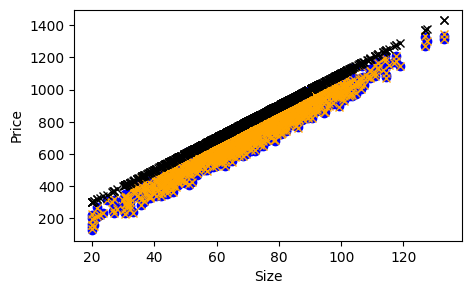

In [127]:
fig=plt.figure(figsize=(5,3))
plt.plot(x[:,0],y,'o',color='blue')
plt.xlabel('Size')
plt.ylabel('Price')
plt.plot(x[:,0],y_hat,'x',color='orange')
plt.plot(x[:,0],x[:,0]*w_true[0]+b_true,'x',color='black')

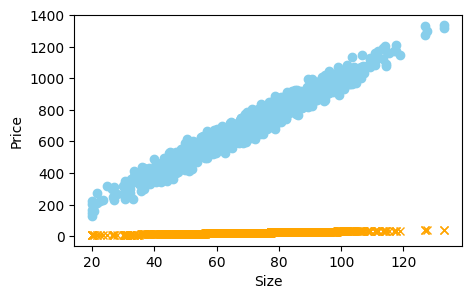

In [128]:
w = torch.tensor([0.3,0.5])
b = 0.
fig=plt.figure(figsize=(5,3))
plt.plot(x[:,0],y,'o',color='skyblue')
plt.xlabel('Size')
plt.ylabel('Price')
plt.plot(x[:,0],x[:,0]*w[0]+b,'x',color='orange')

In [129]:
# use random parameters and check errors
yhat = lin_reg(x,w,b)
err = yhat - y
err

tensor([ -649.8793,  -509.4889,  -888.9475,  -596.0149,  -858.7781,  -279.1534,
        -1017.2495,  -705.0442,  -965.7832,  -666.2720,  -803.8506,  -369.5638,
         -830.8203,  -616.1971,  -539.1356, -1038.1991,  -743.8339,  -606.6544,
         -569.4169,  -869.4340,  -955.3499,  -750.5006,  -966.7122,  -965.8602,
         -676.5104,  -625.0899,  -873.0847,  -505.0762,  -383.8518,  -689.7118,
         -581.4888,  -915.1904,  -468.1981,  -787.5372,  -871.1592,  -659.5745,
         -377.3782,  -877.8458,  -722.1945,  -527.3866,  -895.9537,  -768.2534,
         -646.9484, -1293.3394,  -461.8509,  -740.6397,  -855.2042,  -782.1985,
         -764.8187,  -862.5723, -1231.9812,  -674.9710,  -728.4893,  -456.3631,
         -518.1274,  -563.5342,  -714.2972,  -729.9315,  -942.6944,  -653.6063,
         -656.3797,  -814.8073,  -539.3282,  -613.0729,  -578.9441,  -782.7902,
         -414.1201,  -581.3943,  -646.7074,  -846.3148,  -384.2519,  -706.2502,
         -795.9362,  -236.9289,  -600.96

### Loss function definition

We use squared error loss function $$\mathcal{L} = \frac{1}{n} \sum_{i = 1}^{n} \frac{1}{2}(\hat{y}^{(i)} - y^{(i)})^2$$

In [130]:
# define a function loss_func(labels, preds) -> error
def loss_func(labels,preds):
  err = labels - preds
  return torch.mean(err**2)*0.5

In [131]:
loss_func(lin_reg(x,w_true,b_true),y)

tensor(13.0613)

In [132]:
loss_func(lin_reg(x,w,b),y)

tensor(250774.6562)

### Optimization algorithm

We will use minibatch stochastic gradient descent to update the parameters. The function should update the parameter values by a small step opposite to the gradient direction (which indicates the steepest increase). $\mathbf{w} \leftarrow \mathbf{w} - \alpha \nabla_w$

In [133]:
# Gradients
#print(w.grad,w.requires_grad)
w1 = torch.tensor([0.3,0.5], requires_grad=True)
print(f'grad before {w1.grad}')
b1 = torch.tensor([0.],requires_grad=True)
yht = lin_reg(x,w1,b1)
print(f'grad after {w1.grad}')
loss =  loss_func(lin_reg(x,w1,b1),y)
loss.backward()
print(f'grad after {w1} {w1.grad} {w1.grad_fn}')
print(f'grad after for x {x.grad}')
print(f'grad after for b1 {b1} {b1.grad}')
w1.grad.zero_()
b1.grad.zero_()

yht = lin_reg(x,w1,b1)
loss =  loss_func(lin_reg(x,w1,b1),y)
loss.backward()
print(f'grad after 2 {w1} {w1.grad} {w1.grad_fn}')
print(f'grad after for x 2 {x.grad}')
print(f'grad after for b1 2{b1} {b1.grad}')
#err1 = yht - y
#err1.sum().backward()
#print(w1.grad)
# dir(w1)

grad before None
grad after None
grad after tensor([0.3000, 0.5000], requires_grad=True) tensor([-51796.5586,  -3357.1145]) None
grad after for x None
grad after for b1 tensor([0.], requires_grad=True) tensor([-678.6572])
grad after 2 tensor([0.3000, 0.5000], requires_grad=True) tensor([-51796.5586,  -3357.1145]) None
grad after for x 2 None
grad after for b1 2tensor([0.], requires_grad=True) tensor([-678.6572])


In [156]:
# define a function sgd_step(params, learn_rate, batch_size) that does one step in the gradient updates
def sgd_step(params, learn_rate):
  with torch.no_grad():
    for param in params:
      param -= learn_rate * param.grad
      param.grad.zero_() # Make zero out from the gradient 

### Model training

After all the pieces are ready, we implemen the main training loop. It needs to do the following:

* initiate randomly the linear model parameters $(\mathbf{w}, b)$
* repeat for each epoch (unitl done)
    * load batch of data
    * do linear model precitions with current parameter values
    * calculate loss
    * get gradients
    * update parameter values

In [161]:
# write the training procedure
max_epochs = 1
batch_size = 5
w = torch.zeros(2, requires_grad=True)
b= torch.randn(1, requires_grad=True)
lr = 0.00001
losses = []
for epoch in range(max_epochs):
  for batch in iter_data(x,y,batch_size):
    x_batch, y_batch =  batch[0], batch[1]
    preds =  lin_reg(x_batch,w,b) #Predictions
    loss = loss_func(preds,y_batch)
    loss.backward() # get gradients
    sgd_step([w,b],lr)
    print(f'Loss {loss}')
    losses.append(loss.item()) #extract from tensor a scalar

# Monitoring the code
with torch.no_grad():
  preds=lin_reg(x_batch, w, b)
  loss_monitoring = loss_func(preds,y_batch)
  print(loss_monitoring)

Loss 272826.84375
Loss 285011.0
Loss 180501.734375
Loss 235750.5
Loss 253926.03125
Loss 113671.390625
Loss 142071.109375
Loss 92042.5390625
Loss 156200.65625
Loss 117897.859375
Loss 91087.1328125
Loss 68624.1953125
Loss 48676.58203125
Loss 44616.5234375
Loss 33263.19140625
Loss 43068.85546875
Loss 42033.74609375
Loss 30954.328125
Loss 45908.56640625
Loss 28127.828125
Loss 28147.84375
Loss 28446.662109375
Loss 9209.216796875
Loss 14800.8310546875
Loss 16479.17578125
Loss 9148.087890625
Loss 27762.60546875
Loss 16423.365234375
Loss 13134.384765625
Loss 12829.693359375
Loss 8935.265625
Loss 9278.18359375
Loss 14258.1064453125
Loss 7526.8037109375
Loss 4391.39306640625
Loss 6859.7060546875
Loss 2179.191650390625
Loss 2277.36474609375
Loss 1418.4434814453125
Loss 2483.052001953125
Loss 2940.72998046875
Loss 3686.51318359375
Loss 1537.702880859375
Loss 1985.87890625
Loss 3388.17626953125
Loss 1218.65185546875
Loss 1548.1739501953125
Loss 1548.2593994140625
Loss 4600.01953125
Loss 1561.867065

Text(0.5, 0, 'Iterations')

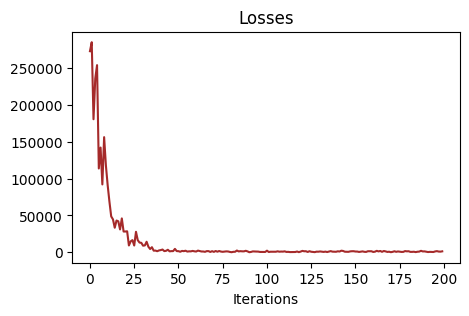

In [167]:
fig = plt.figure(figsize=(5,3))
plt.plot(losses,color = 'brown')
plt.title('Losses')
plt.xlabel('Iterations')

### Normalize imput data

It is usually better to normalize your input data to remove any scaling differences. The normalized data shall have zero mean $\mu$ and standard deviation $\sigma$ 1.
$$x_{norm} = \frac{x - \mu(x)}{\sigma(x)}$$

In [168]:
### Normalize input data so that each input dimension has mean = 0 and std = 1
x_norm = torch.div(torch.subtract(x,torch.mean(x)),torch.std(x))

In [173]:
x_norm

tensor([[ 0.9513, -0.8562],
        [ 0.3061, -0.9732],
        [ 1.5286, -0.9120],
        ...,
        [ 0.3113, -0.8950],
        [ 1.7149, -0.9560],
        [ 1.1273, -1.0198]])

### Plot data again

Just to check the result of the normalization step, plot again the scatter of price agains the normalized size.

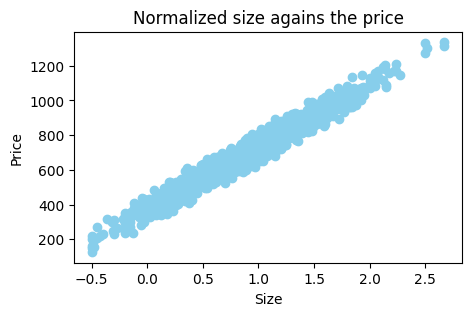

In [176]:
fig=plt.figure(figsize=(5,3))
plt.title('Normalized size agains the price')
plt.xlabel('Size')
plt.ylabel('Price')
plt.plot(x_norm[:,0],y,'o',color='skyblue')

### Train over normalized data

In [177]:
# write the training procedure
max_epochs = 1
batch_size = 5
w = torch.zeros(2, requires_grad=True)
b= torch.randn(1, requires_grad=True)
lr = 0.00001
losses = []
for epoch in range(max_epochs):
  for batch in iter_data(x_norm,y,batch_size):
    x_batch, y_batch =  batch[0], batch[1]
    preds =  lin_reg(x_batch,w,b) #Predictions
    loss = loss_func(preds,y_batch)
    loss.backward() # get gradients
    sgd_step([w,b],lr)
    print(f'Loss {loss}')
    losses.append(loss.item()) #extract from tensor a scalar

# Monitoring the code
with torch.no_grad():
  preds=lin_reg(x_batch, w, b)
  loss_monitoring = loss_func(preds,y_batch)
  print(loss_monitoring)

Loss 273839.53125
Loss 318907.5625
Loss 228500.625
Loss 329169.875
Loss 406100.0625
Loss 217750.546875
Loss 296886.0625
Loss 231430.84375
Loss 393996.8125
Loss 343170.59375
Loss 318461.75
Loss 286851.3125
Loss 224611.34375
Loss 242327.453125
Loss 181745.171875
Loss 294557.34375
Loss 254785.375
Loss 236761.546875
Loss 332731.0625
Loss 285966.90625
Loss 315221.375
Loss 293496.71875
Loss 128230.5625
Loss 217081.84375
Loss 195005.59375
Loss 181760.40625
Loss 438141.34375
Loss 276865.09375
Loss 295875.59375
Loss 280917.0
Loss 294314.21875
Loss 292782.4375
Loss 448221.1875
Loss 321845.09375
Loss 130005.2734375
Loss 287762.4375
Loss 203993.0625
Loss 210209.65625
Loss 190358.703125
Loss 178425.421875
Loss 227316.5
Loss 245117.90625
Loss 276005.28125
Loss 227525.546875
Loss 302206.71875
Loss 285903.84375
Loss 208019.34375
Loss 239905.34375
Loss 317210.1875
Loss 180288.09375
Loss 347448.375
Loss 110965.1484375
Loss 326269.25
Loss 186099.953125
Loss 252035.046875
Loss 253107.796875
Loss 350370.62

Text(0.5, 0, 'Iterations')

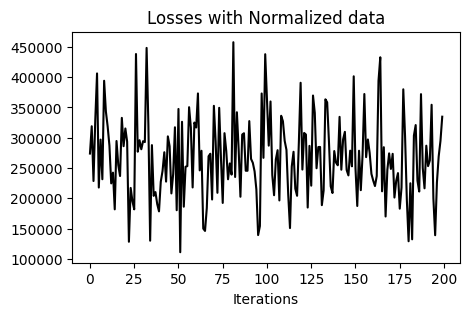

In [180]:
fig = plt.figure(figsize=(5,3))
plt.plot(losses,color = 'black')
plt.title('Losses with Normalized data')
plt.xlabel('Iterations')